# Imports

In [1]:
import torch
import numpy as np
import pickle as pkl
from dataclasses import dataclass
import re
from torch.utils.data import DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration

C:\Users\omarw\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading and Cleaning

In [2]:
@dataclass
class ConversationEntry:

    is_customer: bool
    text: str

@dataclass
class Conversation:

    customer_id: int
    brand_name: str
    entries: list[ConversationEntry] # this alternates between customer entry and agent entry

In [3]:
convos: list[Conversation] = []
with open('../../archive/convos.pkl', 'rb') as f:
    convos = pkl.load(f)

In [4]:
len(convos)

787346

In [3]:
def print_convo(convo: Conversation):
    
    str_len = max(len(convo.brand_name), len(str(convo.customer_id))) + 1

    for entry in convo.entries:
        print((str(convo.customer_id) + ">").ljust(str_len) if entry.is_customer else (convo.brand_name+ ">").ljust(str_len) , end = ' ')
        print(entry.text)

In [6]:
print_convo(convos[100])

115861>        Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I️ try to type the letter I️? Also @AppleSupport https://t.co/QKwvTLtiN7
AppleSupport>  @115861 You're in the right place; we'll do all we can to help. To start, let us know what iOS version is installed via DM: https://t.co/GDrqU22YpT
115861>        @AppleSupport @115861 We’re going to need you to share the answers Angela. I️ can’t stand this! @115862 @AppleSupport I will! @115861 @115862 @AppleSupport I️ upgraded. I️t didn’t work.
AppleSupport>  @115860 Reach out to us via DM, and we can take a look at this with you. https://t.co/GDrqU22YpT
115861>        @115860 @115862 @AppleSupport Didn’t work for me either😔


In [7]:
def clean_message(text: str):
    # Remove links
    text = re.sub(r'http\S+', '', text)
   
    # Remove mentions 
    text = re.sub(r'@\w+', '', text)
    
    # Remove non-ascii characters (to remove emojis, and other languages maybe)
    text = ''.join(char for char in text if ord(char) < 128)

    return text.strip()


In [8]:
import dataclasses

def clean_convos(convos: list[Conversation], copy=True):
    if copy:
        new_convos: list[Conversation] = []

    for c in convos:
        if copy:
            new_entries: list[ConversationEntry] = []

        for e in c.entries:
            cleaned_message = clean_message(e.text)
            if copy:
                new_entries.append(dataclasses.replace(e, text=cleaned_message))
            else:
                e.text = cleaned_message

        if copy:
            new_convos.append(dataclasses.replace(c, entries = new_entries))

    if copy:
        return new_convos         

In [4]:
import os
if os.path.exists('./cleaned'):
    with open('./cleaned', 'rb') as f:
        cleaned_convos = pkl.load(f)
else:
    cleaned_convos = clean_convos(convos, copy=True)
    with open('./cleaned', 'wb') as f:
        pkl.dump(cleaned_convos, f)

In [5]:
print_convo(cleaned_convos[100])

115861>       Hello, internet. Can someone explain why this symbol keeps appearing on my phone and when I try to type the letter I? Also
AppleSupport> You're in the right place; we'll do all we can to help. To start, let us know what iOS version is installed via DM:
115861>       Were going to need you to share the answers Angela. I cant stand this!   I will!    I upgraded. It didnt work.
AppleSupport> Reach out to us via DM, and we can take a look at this with you.
115861>       Didnt work for me either


# Model Loading

In [6]:
tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained('google/t5-efficient-tiny', legacy=False)
# model: T5ForConditionalGeneration = T5ForConditionalGeneration.from_pretrained('google/t5-efficient-tiny')
model: T5ForConditionalGeneration = torch.load('./checkpoint3')

C:\Users\omarw\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
from torch.utils.data import Dataset


class QADataset(Dataset):

    def __init__(self, convos: list[Conversation]):
        
        self.dataset = []

        for c in convos:
            contexts, answers = QADataset.generate_convo_qa_pairs(c)
            
            for con, ans in zip(contexts, answers):
                self.dataset.append((con, ans))

    @staticmethod
    def generate_convo_qa_pairs(convo: Conversation):
        """
        Returns a list of all questions, along with a list of all answers to each question
        """
        entries = convo.entries
        
        contexts = []
        answers = []
        for i in range(len(entries) - 1):
            entry = entries[i]

            if entry.is_customer: # this is a question

                inputs = tokenizer(
                    text=entries[i].text,
                    add_special_tokens=True,
                    padding="max_length",
                    max_length=64,
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors='pt'
                )
                
                output_ids = tokenizer(
                    text=convo.brand_name + ": " + entries[i+1].text,
                    add_special_tokens=True,
                    padding="max_length",
                    max_length=64,
                    truncation=True,
                    return_tensors='pt',
                    return_attention_mask=False
                ).input_ids.squeeze()

                output_ids[output_ids == tokenizer.pad_token_id] = -100
                contexts.append(inputs)
                answers.append(output_ids)

        return contexts, answers

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index: int):
        inputs, ans = self.dataset[index]
        return inputs.input_ids.squeeze(), ans, inputs.attention_mask.squeeze()

        # inputs = tokenizer(
        #     text=con,
        #     add_special_tokens=True,
        #     padding="max_length",
        #     max_length=64,
        #     truncation=True,
        #     return_attention_mask=True,
        #     return_tensors='pt'
        # )
        
        # output_ids = tokenizer(
        #     text=ans,
        #     add_special_tokens=True,
        #     padding="max_length",
        #     max_length=64,
        #     truncation=True,
        #     return_tensors='pt',
        #     return_attention_mask=False
        # ).input_ids.squeeze()

        # # ignore <pad> by the loss
        # output_ids[output_ids == tokenizer.pad_token_id] = -100

        # return inputs.input_ids.squeeze(), output_ids, inputs.attention_mask.squeeze()

In [11]:
SPLIT = 0.8
import random

random.shuffle(cleaned_convos)

cleaned_convos = cleaned_convos[0: int(0.3333 * len(cleaned_convos))]
num_convos = len(cleaned_convos)

train_convos = cleaned_convos[:int(0.8 * num_convos)]
test_convos = cleaned_convos[int(0.8* num_convos): ]

train_dataset = QADataset(train_convos)
test_dataset = QADataset(test_convos)

In [12]:
train_dataset.__getitem__(4)

(tensor([ 9459,   429, 14371,     9,   317,    81, 22107,  1519,     3,     9,
           385,   394,    34,    19,  5098,   997,   189,  1233,   233, 19712,
          3285, 16752,    33,   833,    71, 19046, 16847,  1233,   233,   427,
          2644,     9,  2011,   382,   291,  2782,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 tensor([ 8366,   382,   291,  2782,    10,  1333,    21,     3,  8035,   178,
           214,    81,    48,     5,   101,   103,   240, 11426,   463,   182,
          5830,    11,    62,    31,    60,  5657,    48,   251,   147,    12,
             8,  4857,    77,     9,  8554,  2110,    63,   372,     5,  1563,
           178,   214,     3,    99,    25,  2944,     8,  3285,    11,    62,
            31,   195, 29560,    25,    21,    34,     5,   101,  3653,    25,
          230

In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

12422528

In [14]:
model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 256)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 256)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=256, out_features=256, bias=False)
              (k): Linear(in_features=256, out_features=256, bias=False)
              (v): Linear(in_features=256, out_features=256, bias=False)
              (o): Linear(in_features=256, out_features=256, bias=False)
              (relative_attention_bias): Embedding(32, 4)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=256, out_features=1024, bias=False)
              (wo): Linear(in_features=1024, out_features=256, bias=False)
              (dropout): Drop

In [17]:
tokenizer.batch_decode(tokenizer('Hello, Omar').input_ids)

['Hello', ',', 'O', 'mar', '</s>']

In [15]:
model.get_memory_footprint()

62282752

# Training

In [20]:
@dataclass
class TrainingResult:

    num_epochs: int
    
    train_loss: list[float]
    test_loss: list[float]
    
    train_perplexity: list[float]
    test_perplexity: list[float]

In [17]:
for (batch_index, batch) in enumerate(DataLoader(train_dataset, batch_size=32)):
    print(batch[1].shape)
    break

torch.Size([32, 64])


In [18]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [19]:
for param in model.decoder.parameters():
    param.requires_grad = True

In [20]:
for param in model.lm_head.parameters():
    param.requires_grad = True

In [21]:
model.num_parameters(only_trainable=True)

12422528

In [22]:
from torch.optim.adam import Adam
device = 'cuda'

def train_model(
model,
num_epochs: int, 
train_dataloader: DataLoader, 
test_dataloader: DataLoader, 
verbose: bool=True
) -> TrainingResult:

    optimizer = Adam(params=model.parameters(), lr=3e-4)

    train_losses = []
    test_losses = []

    train_perplexities = []
    test_perplexities = []

    for e in range(num_epochs):
        
        total_train_loss = 0
        total_test_loss = 0

        train_perplexity = 0
        test_perplexity = 0

        model.train()

        for (batch_index, batch) in enumerate(train_dataloader):
            
            (Q_train, A_train, attention_mask) = batch # Q, A = (BATCH_SIZE, SEQ_LENGTH)
            
            if verbose:
                print(f'\rEpoch {e + 1}/{num_epochs}: Batch {batch_index + 1}/{len(train_dataloader)}', end='')

            foward_pass = model.forward(input_ids=Q_train.to(device), labels=A_train.to(device), attention_mask=attention_mask.to(device)) # (BATCH_SIZE, SEQ_LENGTH, VOCAB_SIZE)
            loss = foward_pass.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mean_loss = loss.mean().to('cpu').item()
            total_train_loss += mean_loss

        mean_train_loss = total_train_loss / len(train_dataloader)
        train_perplexity = torch.exp(torch.Tensor([mean_train_loss]))[0].item()
        
        train_losses.append(mean_train_loss)
        train_perplexities.append(train_perplexity)

        # epoch done
        if verbose:
            print(f"\nTrain Results: Loss: {mean_train_loss} | Perplexity: {train_perplexity}")


        # do test eval
        with torch.inference_mode():
            model.eval()

            for (batch_index, batch) in enumerate(test_dataloader):
                
                (Q_test, A_test, attention_mask) = batch # Q, A = (BATCH_SIZE, SEQ_LENGTH)

                forward_pass = model.forward(input_ids=Q_test.to(device), labels=A_test.to(device), attention_mask=attention_mask.to(device))
                
                loss = forward_pass.loss

                mean_loss = loss.mean().to('cpu').item()
                total_test_loss += mean_loss

            mean_test_loss = total_test_loss / len(test_dataloader)
            test_perplexity = torch.exp(torch.Tensor([mean_test_loss]))[0].item()

            test_losses.append(mean_test_loss)
            test_perplexities.append(test_perplexity)

            # epoch done
            if verbose:
                print(f"Test Results:  Loss: {mean_test_loss} | Perplexity: {test_perplexity}")
                print("----------------------------------------")

    return TrainingResult(
        num_epochs=num_epochs,
        train_loss=train_losses,
        test_loss=test_losses,
        train_perplexity=train_perplexities,
        test_perplexity=test_perplexities
    )


In [28]:
t1 = train_model(
    model=model,
    num_epochs=3, 
    train_dataloader=DataLoader(train_dataset, 36), 
    test_dataloader=DataLoader(test_dataset, 36) 
)

Epoch 1/3: Batch 8178/8178
Train Results: Loss: 9.255488750432574 | Perplexity: 10461.8271484375
Test Results:  Loss: 4.861909271102264 | Perplexity: 129.2707977294922
----------------------------------------
Epoch 2/3: Batch 8178/8178
Train Results: Loss: 6.667969923959323 | Perplexity: 786.7965698242188
Test Results:  Loss: 4.151704169088794 | Perplexity: 63.54220199584961
----------------------------------------
Epoch 3/3: Batch 8178/8178
Train Results: Loss: 5.979713709029629 | Perplexity: 395.3272399902344
Test Results:  Loss: 3.900352454022345 | Perplexity: 49.419864654541016
----------------------------------------


In [29]:
t2 = train_model(
    model, 3, DataLoader(train_dataset, batch_size=36), DataLoader(test_dataset, batch_size=36) 
)

Epoch 1/3: Batch 8176/8176
Train Results: Loss: 5.692119832491454 | Perplexity: 296.5214538574219
Test Results:  Loss: 3.8290756123356533 | Perplexity: 46.01997756958008
----------------------------------------
Epoch 2/3: Batch 8176/8176
Train Results: Loss: 5.575459471770695 | Perplexity: 263.8707580566406
Test Results:  Loss: 3.7741466798562953 | Perplexity: 43.560325622558594
----------------------------------------
Epoch 3/3: Batch 35/8176

KeyboardInterrupt: 

In [101]:
t3 = train_model(
    model, 3, DataLoader(train_dataset, batch_size=36), DataLoader(test_dataset, batch_size=36)
)

Epoch 1/3: Batch 8162/8162
Train Results: Loss: 3.0815138576136474 | Perplexity: 21.791366577148438
Test Results:  Loss: 2.434022585218176 | Perplexity: 11.404666900634766
----------------------------------------
Epoch 2/3: Batch 61/8162

KeyboardInterrupt: 

In [23]:
t4 = train_model(
    model, 2, DataLoader(train_dataset, batch_size=36), DataLoader(test_dataset, batch_size=36)
)

Epoch 1/2: Batch 8163/8163
Train Results: Loss: 2.6858557204354354 | Perplexity: 14.670748710632324
Test Results:  Loss: 2.275292629376054 | Perplexity: 9.730766296386719
----------------------------------------
Epoch 2/2: Batch 8163/8163
Train Results: Loss: 2.544431288671978 | Perplexity: 12.735981941223145
Test Results:  Loss: 2.1840001071686856 | Perplexity: 8.881762504577637
----------------------------------------


In [24]:
torch.cuda.empty_cache()

In [25]:
torch.save(model, './checkpoint4')

In [14]:
tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained('google/t5-efficient-tiny', legacy=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load('./checkpoint4').to(device)

C:\Users\omarw\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
training_results = TrainingResult(
    num_epochs=8,
    train_loss=[9.255488750432574, 6.667969923959323, 5.979713709029629, 5.692119832491454, 5.575459471770695, 3.0815138576136474, 2.6858557204354354, 2.544431288671978 ],
    test_loss=[4.861909271102264, 4.151704169088794, 3.900352454022345, 3.8290756123356533, 3.7741466798562953, 2.434022585218176, 2.275292629376054, 2.1840001071686856 ],
    train_perplexity=[10461.8271484375, 786.7965698242188, 395.3272399902344, 296.5214538574219, 263.8707580566406, 21.791366577148438, 14.670748710632324, 12.735981941223145],
    test_perplexity=[129.2707977294922, 63.54220199584961, 49.419864654541016, 46.01997756958008, 43.560325622558594, 11.404666900634766, 9.730766296386719, 8.881762504577637]
)

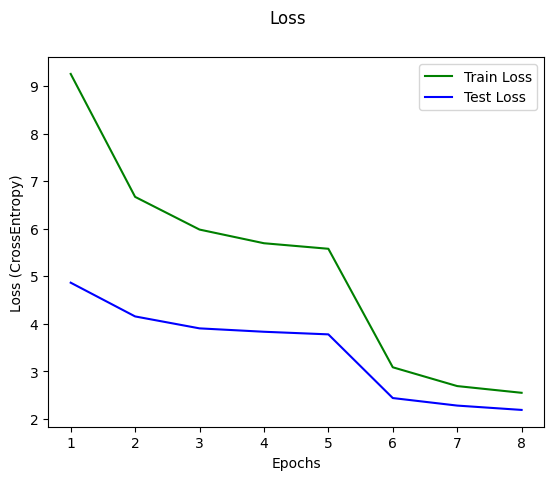

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
fig.suptitle("Loss")

plt.plot(range(1, training_results.num_epochs + 1), training_results.train_loss, color='g', label='Train Loss')
plt.plot(range(1, training_results.num_epochs + 1), training_results.test_loss, color='b', label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (CrossEntropy)")
plt.legend()
plt.show()

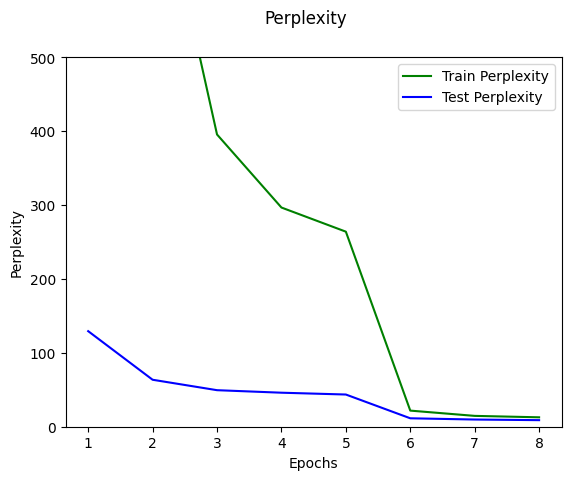

In [39]:
fig = plt.figure(1)
fig.suptitle("Perplexity")

plt.plot(range(1, training_results.num_epochs + 1), training_results.train_perplexity, color='g', label='Train Perplexity')
plt.plot(range(1, training_results.num_epochs + 1), training_results.test_perplexity, color='b', label='Test Perplexity')
plt.xlabel("Epochs")
plt.ylim(bottom = 0, top=500)
plt.ylabel("Perplexity")
plt.legend()
plt.show()

# Output Generation

In [15]:
def generate_output(encoded_batch):
    model.eval()
    with torch.no_grad():
        return model.generate(
            input_ids=encoded_batch['input_ids'],
            attention_mask=encoded_batch['attention_mask'],
            max_new_tokens=60,
            temperature=1.0,
            top_p=0.95,
            top_k=60,
            repetition_penalty=1.0,
            no_repeat_ngram_size=1,
            use_cache=True,
            do_sample=True,
            num_beams=2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )

In [43]:
batch = [
    'Hello, my Iphone stopped working after the latest ios update. Can you help me?',
    'My package has been marked as deliverd, but I didn\'t receive anything. Fix this!!',
    'I missed my doctor appointment today thanks to your driver. Please refund me the money '
    ]

encoded_batch = {
    key: value.to(model.device)
    for key, value in tokenizer(batch, return_tensors='pt', padding=True).items()
}

tokenizer.batch_decode(generate_output(encoded_batch), skip_special_tokens=True)

["AppleSupport: We'd be happy to help. What device are you using?",
 "AmazonHelp: I'm sorry for the delay. When you have a moment, please reach out to us via phone or chat so we can look into this further!KS",
 "Uber_Support: We're here to help! Send us a note at so our team can connect."]

In [44]:
class Chat:

    def __init__(self, model, device) -> None:
        self.model = model
        self.device = device
        self.context = []

    def generate_answer(self, question: str) -> str:
        
        with torch.inference_mode():
            model.eval()
            
            self.context.append(question)

            encoded_batch = {
                key: value.to(model.device)
                for key, value in tokenizer(' '.join(self.context), return_tensors='pt', padding=True).items()
            }

            out = generate_output(encoded_batch)
            answer = tokenizer.batch_decode(out, skip_special_tokens=True)[0]

            self.context.append(answer)
            return answer

In [45]:
c = Chat(model, device)

while True:
    try:
        print("Client> ", end='')
        question = input()
        print(question)
        answer = c.generate_answer(question)
        print("Agent> ", answer)
    except KeyboardInterrupt:
        break

Client> My internet conneciton is down for the last few hours. I cant work like that
Agent>  Ask_Spectrum: I apologize for the issues you are having with your internet. Please send me a direct message, full address and phone number so we can look into this further? Thanks-JB
Client> I sent you a DM. Can you take a look at it for me?
Agent>  Ask_Spectrum: I apologize for the inconvenience. If you would like me to look into your account, please send us a direct message with an email address so we can follow up and assist further!-JP
Client> I said I sent you a DM
Agent>  Ask_Spectrum: I apologize for the inconvenience. Please DM your account number, phone # and address so we can look into this further with you? We will be happy to help!SB
Client> 

In [46]:
c = Chat(model, device)

while True:
    try:
        print("Client> ", end='')
        question = input()
        print(question)
        answer = c.generate_answer(question)
        print("Agent> ", answer)
    except KeyboardInterrupt:
        break

Client> The flight attendant was rude to me during my previous flight
Agent>  Delta: Please DM your confirmation number so I can assist you further. *TJH
Client> My number is 193-203-123
Agent>  Delta: I'm sorry for the delay. Please DM your confirmation number so we can look into this with you? *TJH
Client> I already gave it to you
Agent>  Delta: Hi, Ryan. Please DM your confirmation number so I can look into this for you? *AMC
Client> 
Agent>  Delta: Hi, James. Please DM your confirmation number so I can look into this for you! *AFM
Client> 

In [47]:
c = Chat(model, device)

while True:
    try:
        print("Client> ", end='')
        question = input()
        print(question)
        answer = c.generate_answer(question)
        print("Agent> ", answer)
    except KeyboardInterrupt:
        break

Client> Hello, my package was damaged when it arrived. Can I refund the order?
Agent>  AmazonHelp: I'm sorry to hear this. Can you tell us more about what happened? SH
Client> Your driver was careless with the package and everything was destroyed when I opened it
Agent>  AmazonHelp: I'm sorry to hear this. Have you tried resetting your package? Let us know in real-time for the tracking and assistance with anything else!MA
Client> :(
Agent>  AmazonHelp: We'd like to look into this with you. Please reach out via phone or chat at the link provided earlier so we can assist further! MS
Client> What is your phone number
Agent>  AmazonHelp: I'm sorry for the delay. We are here to help! Can you please let us know more about what happened? JH
Client> Give me your phoneeee
Agent>  AmazonHelp: I'm sorry to hear about the delay. Could you confirm if your package was damaged? You can find more info here for further assistance with this via email and we will look into it soon!JH
Client> 